In [1]:
# pip install lightgbm
# pip install ipywidgets

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [92]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score
import time
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier
import xgboost as xgb

try:
    # To enable interactive mode you should install ipywidgets
    # pip install ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

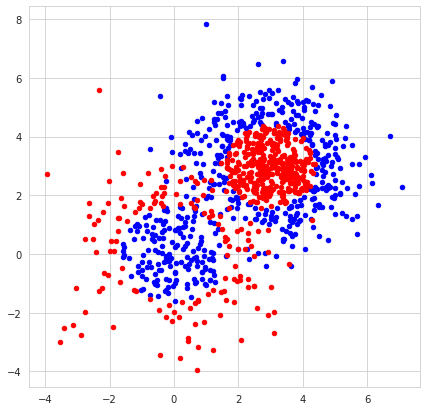

In [129]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(7,7))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='binary')

metrics = ['binary_logloss','auc']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 10,
          verbose = 10,
          feature_name = ['X','Y'])

Training until validation scores don't improve for 10 rounds
[10]	Training data's binary_logloss: 0.396188	Training data's auc: 0.95773	Test data's binary_logloss: 0.432724	Test data's auc: 0.926683
[20]	Training data's binary_logloss: 0.293311	Training data's auc: 0.969216	Test data's binary_logloss: 0.354959	Test data's auc: 0.935847
[30]	Training data's binary_logloss: 0.241095	Training data's auc: 0.97942	Test data's binary_logloss: 0.30914	Test data's auc: 0.948718
[40]	Training data's binary_logloss: 0.214129	Training data's auc: 0.981157	Test data's binary_logloss: 0.288035	Test data's auc: 0.951773
[50]	Training data's binary_logloss: 0.190876	Training data's auc: 0.985027	Test data's binary_logloss: 0.261932	Test data's auc: 0.963341
[60]	Training data's binary_logloss: 0.1716	Training data's auc: 0.987664	Test data's binary_logloss: 0.244329	Test data's auc: 0.9689
[70]	Training data's binary_logloss: 0.156551	Training data's auc: 0.989899	Test data's binary_logloss: 0.231798

LGBMClassifier(max_depth=4, num_leaves=7, objective='binary')

In [150]:
def render_metric(metric_name):
    ax = lgb.plot_metric(model.evals_result_, metric=metric_name, figsize=(10, 5))
    plt.show()
    
def plot_metrics():
    if INTERACTIVE:
        # create widget to switch between metrics
        interact(render_metric, metric_name=metrics)
    else:
        for metric in metrics:
            render_metric(metric)

In [151]:
plot_metrics()

interactive(children=(Dropdown(description='metric_name', options=('binary_logloss', 'auc'), value='binary_log…

In [97]:
ypred = model.predict(X_test)

matrix = confusion_matrix(y_test, ypred)
print(matrix)

print(model.score(X_test, y_test))

[[87 12]
 [ 8 93]]
0.9


In [98]:
def plot_decision_boundary(model, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = model.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = model.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

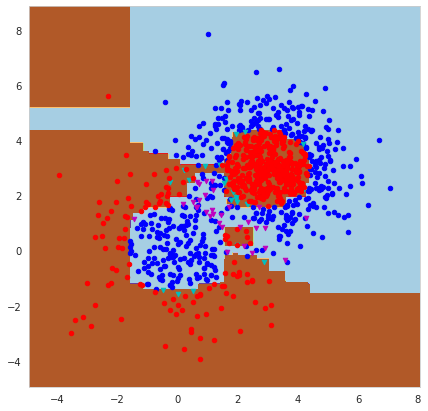

In [99]:
plot_decision_boundary(model,X,y)

In [100]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(model, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

def plot_trees():
    if INTERACTIVE:
        # create widget to switch between trees and control info in nodes
        interact(render_tree,
                 tree_index=(0, model.best_iteration_ - 1),
                 show_info=SelectMultiple(  # allow multiple values to be selected
                     options=['None',
                              'split_gain',
                              'internal_count',
                              'data_percentage'],
                     value=['None']),
                 precision=(0, 4))
        tree = None
    else:
        tree = render_tree(2, ['None'])
    
    tree

In [101]:
plot_trees()

interactive(children=(IntSlider(value=40, description='tree_index', max=80), SelectMultiple(description='show_…

## Examples

#### NIST

In [102]:
from sklearn import datasets

digits = datasets.load_digits()
#print(digits.DESCR)

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [103]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.45305	Test data's multi_logloss: 0.547865
[20]	Training data's multi_logloss: 0.15143	Test data's multi_logloss: 0.259069
[30]	Training data's multi_logloss: 0.0563941	Test data's multi_logloss: 0.147647
[40]	Training data's multi_logloss: 0.0222879	Test data's multi_logloss: 0.10195
[50]	Training data's multi_logloss: 0.0093448	Test data's multi_logloss: 0.0832784
[60]	Training data's multi_logloss: 0.00403666	Test data's multi_logloss: 0.0747559
Early stopping, best iteration is:
[64]	Training data's multi_logloss: 0.00296852	Test data's multi_logloss: 0.0744118


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [104]:
plot_metrics()
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Generalization score : 0.978


#### Wine

In [105]:
wine = datasets.load_wine()
#print(wine.DESCR)

X = wine.data
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [106]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.324988	Test data's multi_logloss: 0.425025
[20]	Training data's multi_logloss: 0.121422	Test data's multi_logloss: 0.230398
[30]	Training data's multi_logloss: 0.048709	Test data's multi_logloss: 0.161252
[40]	Training data's multi_logloss: 0.0209649	Test data's multi_logloss: 0.122353
[50]	Training data's multi_logloss: 0.00807495	Test data's multi_logloss: 0.106682
[60]	Training data's multi_logloss: 0.00335472	Test data's multi_logloss: 0.0860821
[70]	Training data's multi_logloss: 0.00128862	Test data's multi_logloss: 0.079691
Early stopping, best iteration is:
[66]	Training data's multi_logloss: 0.00190335	Test data's multi_logloss: 0.0766672


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [107]:
plot_metrics()
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Generalization score : 0.978


## Comparaison XGBoost et LightGBM

# A complete exemple : Classification of stars, Galaxies, Quasars

For this first application of XGBoost, we will try to classify observations of space to be either stars, galaxies or quasars.
We are using data from the [Sloan Digital Sky Survey](http://www.sdss.org/)

### About the SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [108]:
sdss_df = pd.read_csv('./data/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [109]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## Data Analysis

Before applying any classification algorithm, let's look a bit more and transform the data : first we remove the column that obviously won't help classify into the correct class, such as the objects id and parameters of the camera at the moment of observation.

In [110]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Next we look at a few interesting features (univariate analysis) : by plotting the distribution of each class along this feature, we can estimate if this feature can help in classifying the data.

For instance, we can see that redshift seems to have good correlation, while declination does not differ significantly between the 3 classes.

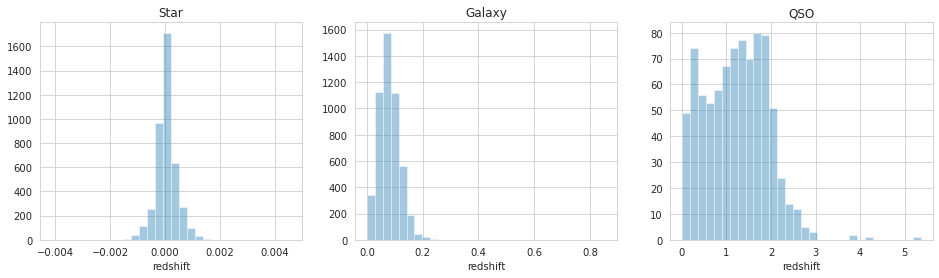

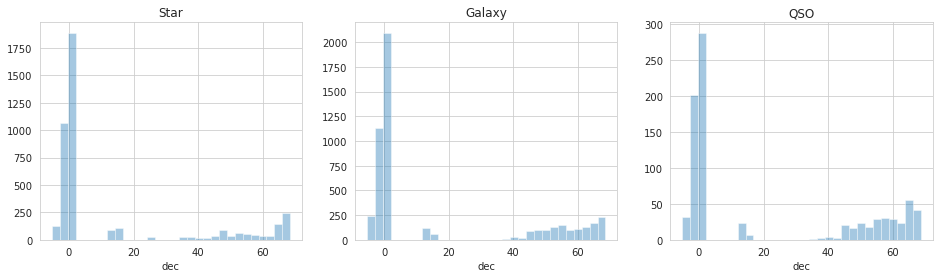

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].dec, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].dec, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].dec, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Finally, we transform a few features : we transform the different bands through a PCA, we encode the classes and scale the extreme values.

In [112]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [113]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

## Classification

#### LightGBM

We will try to tune the parameters of the classificator :

In [152]:
X_train, X_test, y_train, y_test = train_test_split(sdss,y_encoded, test_size=0.2)

In [181]:
from sklearn.model_selection import GridSearchCV

def tune_param(model, rate, estimators):
    
    if model == 'lgb':
        model = LGBMClassifier(boosting_type='gbdt',
                               learning_rate = rate,
                               n_estimators=estimators,
                               objective='multiclass')

        param_test = {
         'num_leaves':[3,5,7,9],
         'max_depth':[3,5,7]
        }
    
    elif model == 'xgb':
        model = XGBClassifier(n_estimators = estimators,
                              learning_rate = rate,
                              objective='multiclass',
                              eval_metric='mlogloss')

        param_test = {
         'max_depth':[3,5,7],
         'min_child_weight':[1,3,5]
        }
        
    else :
        print("Error : model must be 'lgb' or 'xgb'. ")
        
    gsearch1 = GridSearchCV(estimator = model, param_grid = param_test, cv=10)
    gsearch1.fit(X_train, y_train)
    
    print("Best parameters: ", gsearch1.best_params_)
    print("Best score: ", gsearch1.best_score_)
    
    return gsearch1.best_params_

In [174]:
rate=0.1
estimators=100
best_params = tune_param('lgb', rate, estimators)

Best parameters:  {'max_depth': 7, 'num_leaves': 9}
Best score:  0.9924999999999999


In [175]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = best_params['num_leaves'],
                       max_depth = best_params['max_depth'],
                       learning_rate = rate,
                       n_estimators = estimators,
                       objective='multiclass')

metrics = ['multi_logloss']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 20,
          verbose = 10)

end = time.time()

Training until validation scores don't improve for 20 rounds
[10]	Training data's multi_logloss: 0.194451	Test data's multi_logloss: 0.195753
[20]	Training data's multi_logloss: 0.065234	Test data's multi_logloss: 0.071398
[30]	Training data's multi_logloss: 0.0310295	Test data's multi_logloss: 0.0408516
[40]	Training data's multi_logloss: 0.0184712	Test data's multi_logloss: 0.0329784
[50]	Training data's multi_logloss: 0.0119063	Test data's multi_logloss: 0.0306834
[60]	Training data's multi_logloss: 0.00872284	Test data's multi_logloss: 0.0301372
[70]	Training data's multi_logloss: 0.00647569	Test data's multi_logloss: 0.0300905
[80]	Training data's multi_logloss: 0.00487544	Test data's multi_logloss: 0.0306557
Early stopping, best iteration is:
[67]	Training data's multi_logloss: 0.00709243	Test data's multi_logloss: 0.0298538


In [176]:
plot_metrics()
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))
print('Elapsed time : {}s'.format(round(end-start,3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 0.999
Generalization score : 0.99
Elapsed time : 0.306s


In [160]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting': 'gbdt',
    'num_leaves': 8,
    'max_depth': 3,
    'learning_rate': 0.1,
    'metric': ['multi_logloss'],
    'verbose': 10,
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_round': 20,
    'verbosity': -1
}

evals_result = {}  # to record eval results for plotting

start = time.time()

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,
                verbose_eval=10)

end = time.time()

preds = gbm.predict(X_test)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))

print('Elapsed time : {}s'.format(round(end-start,3)))

Training until validation scores don't improve for 20 rounds
[10]	training's multi_logloss: 0.197891	valid_1's multi_logloss: 0.198606
[20]	training's multi_logloss: 0.0695758	valid_1's multi_logloss: 0.0730467
[30]	training's multi_logloss: 0.0357982	valid_1's multi_logloss: 0.0413129
[40]	training's multi_logloss: 0.0247538	valid_1's multi_logloss: 0.0328093
[50]	training's multi_logloss: 0.0193367	valid_1's multi_logloss: 0.0302512
[60]	training's multi_logloss: 0.0161367	valid_1's multi_logloss: 0.0296259
[70]	training's multi_logloss: 0.0138612	valid_1's multi_logloss: 0.029776
[80]	training's multi_logloss: 0.0117514	valid_1's multi_logloss: 0.0297704
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.0155937	valid_1's multi_logloss: 0.0295599
0.9815568776182829
Elapsed time : 0.231s


### XGBoost

In [70]:
param = {
    'learning_rate': 0.1,
    'objective': 'multi:softprob',
    'num_class': 3,
    "n_estimators":200,
    "max_depth":7,
    'num_leaves': 9,
    'verbose': 10
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

start = time.time()

bst = xgb.train(param, dtrain) #, early_stopping_rounds=20)

end = time.time()

preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))

print('Elapsed time : {}s'.format(round(end-start,3)))

[11:48:38] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators, num_leaves, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:48:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9907866338823467
Elapsed time : 0.227s


In [182]:
best_params = tune_param('xgb', rate, estimators)

/home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

In [178]:
model = XGBClassifier( min_child_weight = best_params['min_child_weight'],
                       max_depth = best_params['max_depth'],
                       learning_rate = rate,
                       n_estimators = estimators,
                       objective='multiclass')

metrics = ['mlogloss']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_metric = metrics,
          early_stopping_rounds = 20,
          verbose = 10)

end = time.time()

[0]	validation_0-mlogloss:0.95725	validation_1-mlogloss:0.95775
[10]	validation_0-mlogloss:0.30525	validation_1-mlogloss:0.30814
[20]	validation_0-mlogloss:0.11684	validation_1-mlogloss:0.12145
[30]	validation_0-mlogloss:0.05122	validation_1-mlogloss:0.05727
[40]	validation_0-mlogloss:0.02737	validation_1-mlogloss:0.03526
[50]	validation_0-mlogloss:0.01731	validation_1-mlogloss:0.02760
[60]	validation_0-mlogloss:0.01275	validation_1-mlogloss:0.02472
[70]	validation_0-mlogloss:0.01012	validation_1-mlogloss:0.02394
[80]	validation_0-mlogloss:0.00842	validation_1-mlogloss:0.02368
[90]	validation_0-mlogloss:0.00720	validation_1-mlogloss:0.02348
[99]	validation_0-mlogloss:0.00629	validation_1-mlogloss:0.02343


In [179]:
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))
print('Elapsed time : {}s'.format(round(end-start,3)))

plot_metrics()

Training score : 0.998
Generalization score : 0.993
Elapsed time : 1.864s


interactive(children=(Dropdown(description='metric_name', options=('mlogloss',), value='mlogloss'), Output()),…